# Set Up Google Colab and Import Dependencies

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from sklearn.model_selection import train_test_split


# Download and Prepare the MNIST Dataset

In [9]:
# Load the MNIST dataset
(x_train, _), (x_test, _) = mnist.load_data()

# Normalize the input data to [0, 1]
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Flatten the images for the fully connected layers
x_train = x_train.reshape((len(x_train), 28 * 28))
x_test = x_test.reshape((len(x_test), 28 * 28))

# Reduce the size of the dataset
reduced_size_train = int(len(x_train) * 0.3)
reduced_size_test = int(len(x_test) * 0.2)

# Randomly sample from the dataset
x_train = x_train[:reduced_size_train]
x_test = x_test[:reduced_size_test]

# Split the training data into training and validation sets (80% training, 20% validation)
x_train, x_val = train_test_split(x_train, test_size=0.2, random_state=42)

# Output the new shapes to verify the reduction and split
print(f"Reduced training data shape: {x_train.shape}")
print(f"Validation data shape: {x_val.shape}")
print(f"Reduced testing data shape: {x_test.shape}")


Reduced training data shape: (14400, 784)
Validation data shape: (3600, 784)
Reduced testing data shape: (2000, 784)


Define the Contractive Loss Function

In [10]:
class ContractiveLossLayer(Layer):
    def __init__(self, lam=1e-4, **kwargs):
        super(ContractiveLossLayer, self).__init__(**kwargs)
        self.lam = lam

    def call(self, inputs):
        original, encoded, decoded = inputs

        # Mean squared error between original and reconstructed images
        mse = K.mean(K.square(original - decoded), axis=1)

        # Compute the Jacobian matrix of the encoded output with respect to the input
        dh = K.gradients(encoded, original)[0]
        dh_squared = K.square(dh)

        # Frobenius norm of the Jacobian
        contractive = self.lam * K.sum(dh_squared, axis=1)

        # Contractive loss combines the MSE and the Frobenius norm of the Jacobian
        return mse + contractive

    def compute_output_shape(self, input_shape):
        return (input_shape[0][0],)


# Build the Contractive Autoencoder Model

In [11]:
# Build the Contractive Autoencoder Model
def build_contractive_autoencoder(input_dim, lam=1e-4):
    # Encoder
    input_img = layers.Input(shape=(input_dim,))
    encoded = layers.Dense(512, activation='relu')(input_img)
    encoded = layers.Dense(256, activation='relu')(encoded)
    encoded = layers.Dense(128, activation='relu')(encoded)
    encoded = layers.Dense(64, activation='relu')(encoded)
    encoded = layers.Dense(32, activation='relu')(encoded)

    # Decoder
    decoded = layers.Dense(64, activation='relu')(encoded)
    decoded = layers.Dense(128, activation='relu')(decoded)
    decoded = layers.Dense(256, activation='relu')(decoded)
    decoded = layers.Dense(512, activation='relu')(decoded)
    decoded = layers.Dense(input_dim, activation='sigmoid')(decoded)

    # Contractive loss layer for training
    contractive_loss = ContractiveLossLayer(lam=lam)([input_img, encoded, decoded])

    # Model for training
    autoencoder_train = Model(inputs=input_img, outputs=contractive_loss)
    autoencoder_train.compile(optimizer='adam', loss=lambda y_true, y_pred: y_pred)

    # Model for inference (encoding and decoding)
    autoencoder_inference = Model(inputs=input_img, outputs=decoded)

    return autoencoder_train, autoencoder_inference

input_dim = x_train.shape[1]  # This should be 28*28 = 784
autoencoder_train, autoencoder_inference = build_contractive_autoencoder(input_dim)

# Train the Contractive Autoencoder

In [12]:
# Train the autoencoder
autoencoder_train.fit(x_train, x_train,
                                epochs=20,
                                batch_size=64,
                                shuffle=True,
                                validation_data=(x_val, x_val))

Epoch 1/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0932 - val_loss: 0.0525
Epoch 2/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0484 - val_loss: 0.0369
Epoch 3/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0351 - val_loss: 0.0305
Epoch 4/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0295 - val_loss: 0.0272
Epoch 5/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0265 - val_loss: 0.0251
Epoch 6/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0243 - val_loss: 0.0235
Epoch 7/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0225 - val_loss: 0.0218
Epoch 8/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0209 - val_loss: 0.0205
Epoch 9/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0199 - val_loss: 0.0194
Epoch 10/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0187 - val_loss: 0.0188
Epoch 11/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0179 - val_loss: 0.0185
Epoch 12/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

# Evaluate the Autoencoder and Perform Inference

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Shape of decoded_imgs: (2000, 784)


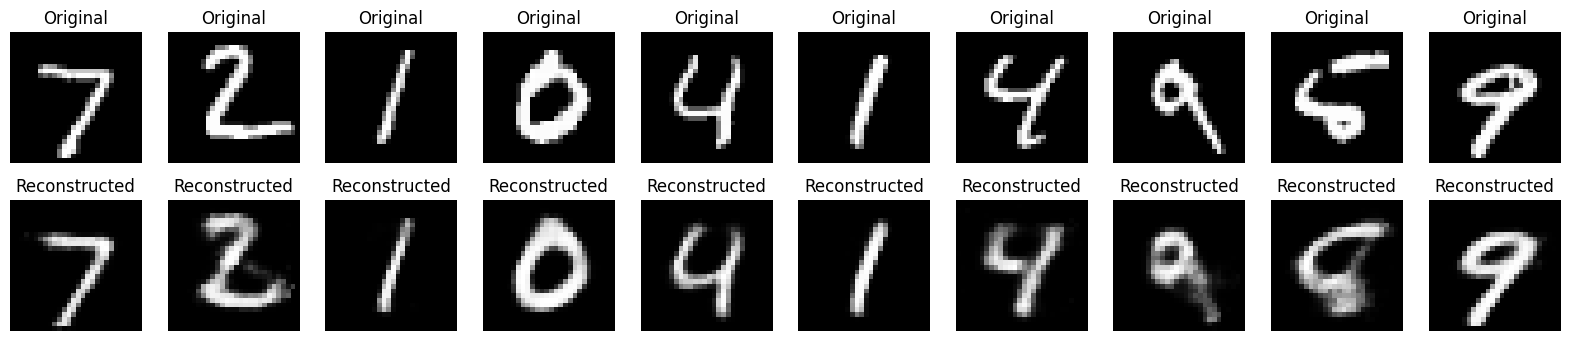

In [13]:
# Use the inference model to predict decoded images
decoded_imgs = autoencoder_inference.predict(x_test)

# Print the shape of the decoded images
print("Shape of decoded_imgs:", decoded_imgs.shape)

# Display the original and decoded images
n = 10  # Number of digits to display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')
plt.show()